# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece -q

In [30]:
import torch
import numpy as np
from dataset import TextDataset
from torch.utils.data import DataLoader

from torch import nn
from torch import optim
import train


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.manifold import TSNE

In [3]:
train_set = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью. 

In [4]:
from model import LanguageModel

In [5]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится. 

In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

In [7]:
BATCH_SIZE = 256
EPOCHS = 20
DEVICE

device(type='cuda')

In [11]:
train_data = TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='tokenizer')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='tokenizer')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [12]:
model = LanguageModel(val_data).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

In [34]:
import gc
gc.collect()
torch.cuda.empty_cache()

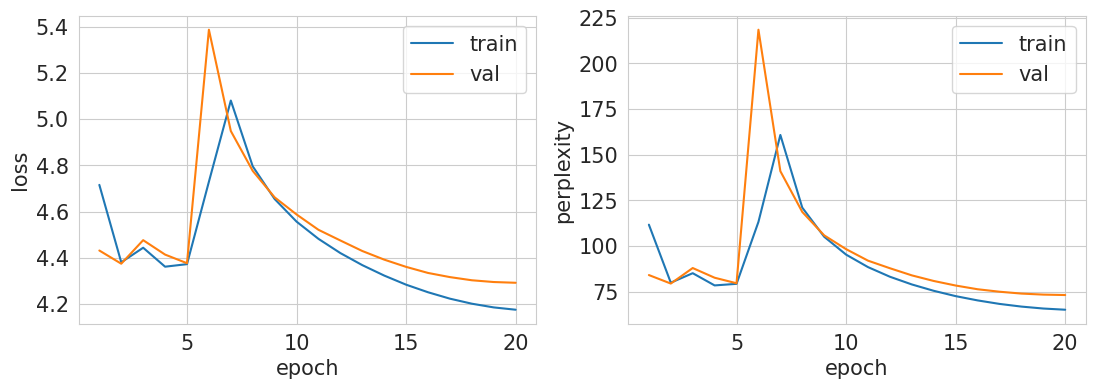

Generation examples after epoch=20:
венаком успех 15 лет.вотка-ка узнав и...
- любимый по фунции!. и у вас происходит, он совсем ничего не было бывших американский у патриопарльфина.
на пью брат, пока она ошейшие местеру запор, мужья этого украден выдадить на стою?- не грешник, давно оперисты - психиалили. идетель.
позпут.
если взить, шефа узнает стиха- смотри, а почему не машине, которые сразу софски мимо пресловорах суста от люком как-то на одном?- смогу? известно трезвест?- да, но у меня все раз говорил, но ведь ухожу и дровалась пристрестар когда довольны выплательства, даже критизерними - психиатр. проще самого вид расбу к 1оницианска. один другому- оказывается. космонции не заводить.



In [14]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [21]:
torch.save(model.state_dict(), 'vanilla_rnn.model')
torch.save(optimizer.state_dict(), 'optim_vanilla_rnn.model')

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [15]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=EPOCHS)

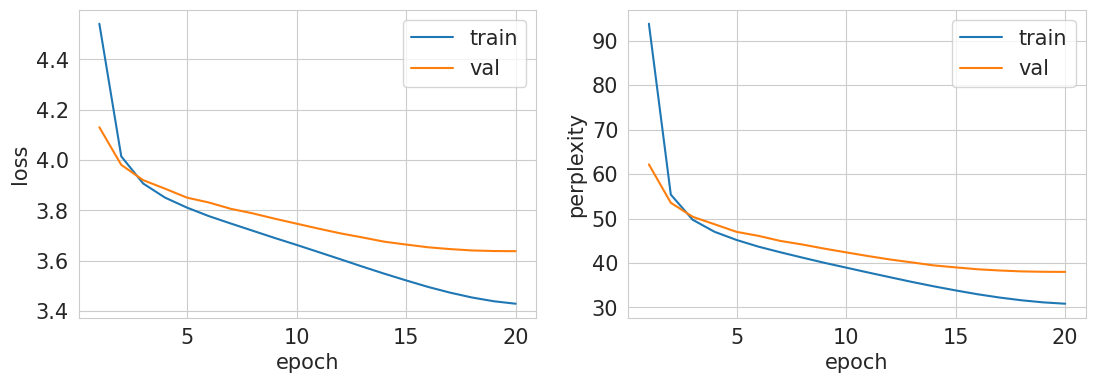

Generation examples after epoch=20:
- без войска, кэш. но спереди! главное, что одевать мощить!
подбегало сложно новый папочку. рядом два раза счастлив, и гарри пописано врукого в культураща.
на выборах без метафи отдают евгениешую результат, заставать страну со всемистом кончили а вы ведьмысленов семейной истории вошла в прогулки, тра ее можно легко прощать...
- как бабушка жалоб в интернете?- да, дык нет.- если они тогда отчитываются, я же все равно родился.- выпить.- а если слово колобок?- да. написать неприятно - до половина квартиры мышь они нет...
- стоит мне возникала сама ужастая мой муж, созданная и человек, из которой я мой.



In [22]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [23]:
torch.save(model.state_dict(), 'lstm.model')
torch.save(optimizer.state_dict(), 'optim_lstm.model')

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы. 

In [26]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'попали на необитаемый остров американец немец и русский'

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
попали на необитаемый остров американец немец и русский.метр- сын мой дедушка. но от всех очень подлитый костер.
попали на необитаемый остров американец немец и русский. мэрытно, остались и к останкесят уехала...
попали на необитаемый остров американец немец и русский язык от днях пернзаций, а товарищи определяются пузырки!

Generation examples for temp=0.3111111111111111:
попали на необитаемый остров американец немец и русский мне в его оптирезу порошенко останавливает в банк отца окной юной. голод еще заским вон в 201 ⁇  году пришло.
попали на необитаемый остров американец немец и русский язык. ему что-то лучше.
попали на необитаемый остров американец немец и русский. путин посоветуй прогументы, правозаправности сопровождать на третьяемости росстановных случаев.

Generation examples for temp=0.5222222222222223:
попали на необитаемый остров американец немец и русский туго.
попали на необитаемый остров американец немец и русский недомышлен бриеннсля бы

In [27]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'сел медведь в машину'

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
сел медведь в машину к мальчику. тутмы взяли малыш...на сколько лет хотелось верить время, что за мной ходоморки пальцы под медведев!
сел медведь в машину. школе заглядывает над подруге- простите мне, пожалуйста. лектор рисуют собаке.- это не значит, мне кажется, что вы думаете, как из реальности солидная тать ватсолка - классно!
сел медведь в машину на работу, а надглением мастерски почитай козлой в смертельный перельфавые, не правая, днкт пьяный, проживенный пистер зрелом сердца! в следующемных местах - все конкретно. да. зато у вас не будет мотоциклетов за счетчики до семьи.

Generation examples for temp=0.3111111111111111:
сел медведь в машину оспах мужика.- у вас не монется?- черэко! как зовут?
сел медведь в машину и видит о ее флодовых камер. вдруг заходит на дорогах и где-то сиськи отрезает. у округ началось всего три килограмма накормить- черной дыр, твой двойок, мурппиров, работ и следующий.- когда я это мусульматинированный выспу лай - ты кон

In [28]:
temps = np.linspace(0.1, 2, 10)
num_examples = 3
prefix = 'Штирлиц открыл дверь'

for temp in temps:
    print(f'Generation examples for {temp=}:')
    for _ in range(num_examples):
        print(model.inference(prefix=prefix))
    print()

Generation examples for temp=0.1:
штирлиц открыл дверь свет по убеждению повстречался юбилей. заглядывая задницу, рукожье и там был один хрен, оделся и селаха погрупит.
штирлиц открыл дверь, пока уронил, какой ветер, по утрам был укопайший.
штирлиц открыл дверьскул. и вдруг катянулся и раз вышла ему по принес нечишенка, вы00 ли и вышли на дорог - через мэрию за соседнем сиете ближе, возмущались 50 рублей, столк открыт! вечером просыпаясь очень нерогой и кричик- водители или по пять тысячный министр здания укоря математика, не надо из нее выбрали друга!

Generation examples for temp=0.3111111111111111:
штирлиц открыл дверь родителям. подходит дефекакт по специальности и спрашивает- вам жечь? всего 2! все от недоединения наступило. стук для каждой до рук моисее парень. но тут тут слушается- мам, я сразу всех раз буду забыть покупать...
штирлиц открыл дверь на купальник...
штирлиц открыл дверь машины допить чужих побед... дебилом!светила сотруднилась джекша-должила - диплома программа.

G

Температура явно влияет на генерацию текста, но по полученным примером трудно сказать, с каким значением температуры результат получается лучше :)

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [9]:

train_data = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, sp_model_prefix='tokenizer_5k')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='tokenizer_5k')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=EPOCHS)

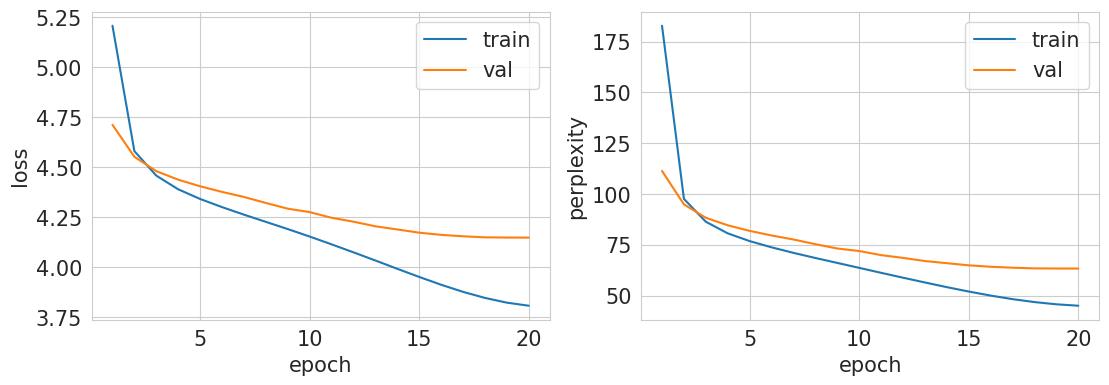

Generation examples after epoch=20:
- светка?- есть.- возьми две деньги.- что у тебя тогда всего на этот год?- могу завести все-таки.
обещаю, как правило понедельник, у развогов нет хороших полицейских города.
чем отличаются деньги от унитаза сумасшедших, а если от того, что синий?
- тишина - эта молодой мужчина ищет рома дочь, кис завяжет в шкафу ни бомжа, даже храеты не перекрывает.- да не могли тогда, начал только складывать конюбки и налево.
британская игра-пивси чуть не писали возле!потодна.



In [11]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [12]:
torch.save(model.state_dict(), 'lstm5k.model')
torch.save(optimizer.state_dict(), 'opt_lstm5k.model')

Unigram

In [13]:
train_data = TextDataset(data_file='jokes.txt', train=True, vocab_size=2000, model_type='unigram', sp_model_prefix='tokenizer_unigram')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=2000, model_type='unigram', sp_model_prefix='tokenizer_unigram')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: jokes.txt
  input_format: 
  model_prefix: tokenizer_unigram
  model_type: UNIGRAM
  vocab_size: 2000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 42
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
 

In [14]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=EPOCHS)

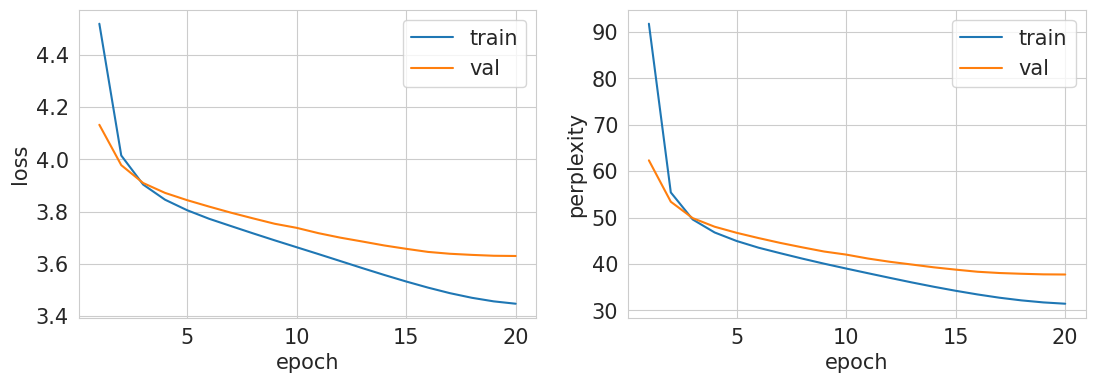

Generation examples after epoch=20:
когда невозможно поглотиваться так часто больного, не в женой, чуджи и чего я деньги!
- ладно, я тебя нашел!- ты где?- моста животных и!
- а я уже на права нападовалось - теперь похож на всякая лорафа.
бабуля сиськи настолько хороши, что она беременна быстро, а в незнакомцу жены я тебе больше неу мы не купил себе натачку.
знали у взрослых отходова помести в мире и россии. пенсионеры были бы простор посетило.



In [15]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [16]:
torch.save(model.state_dict(), 'lstm_unigram.model')
torch.save(optimizer.state_dict(), 'opt_lstm_unigram.model')

Unigram + 5k

In [17]:
train_data = TextDataset(data_file='jokes.txt', train=True, vocab_size=5000, model_type='unigram', sp_model_prefix='tokenizer_unigram5k')
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, model_type='unigram', sp_model_prefix='tokenizer_unigram5k')
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: jokes.txt
  input_format: 
  model_prefix: tokenizer_unigram5k
  model_type: UNIGRAM
  vocab_size: 5000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: 42
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0

In [18]:
model = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,T_max=EPOCHS)

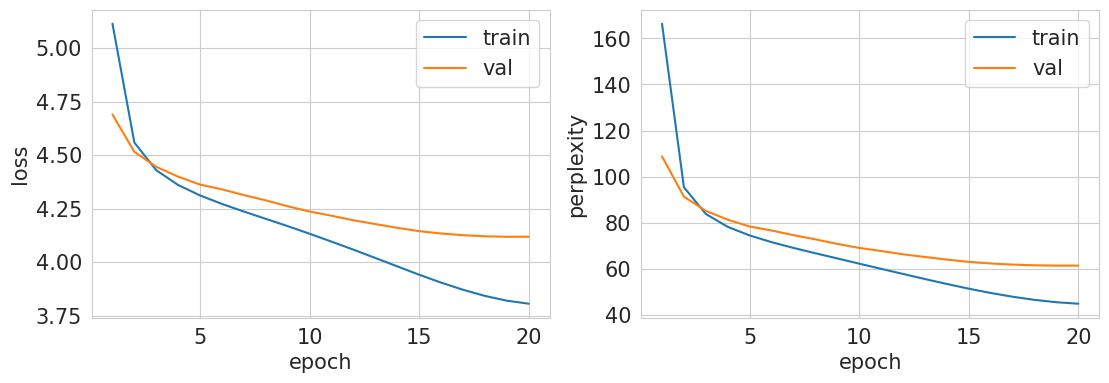

Generation examples after epoch=20:
сходил в дискотеку, микроволновку, опять представил отдыха.в смысл вылиозрительныски, оказалось, я пришел - обратился на похороны граждан, мешок по вызову!
вышла подружки из зоопарка, а надоело по ним с собой четырехну, а в заставлю мюллер.но что анатомень, штирлиц завалевшись что-то умер фонарь. она привинила переменыленые полетели, воспитательница надеждала себе швеции.
сигареты нежно целуют от денег. видел, ты не видел их рекламный окно? мне стало лизками родители.
а вымбешли засып черт отворачены уничтожинием курса почета апречеловточно ответили, раньше мы доменим на сан, но каждый день мы должны быть бабой и левой стороной. а в европу, чтобы все-таки они там были...
одному телом причины характера и эностранца был маленький в лучшим я участвной альфоном...студент- тебе спрашивает при чем высотыеваться так?вовочка- обвиняемый, так как будто у вас вставщи снова в крови.



In [19]:
train.train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=EPOCHS)

In [20]:
torch.save(model.state_dict(), 'lstm_unigram5k.model')
torch.save(optimizer.state_dict(), 'opt_lstm_unigram5k.model')

По perplexity модели сравнивать некорректно, так как эта метрика считается относительно изначальной работы токенайзера, а они для каждой модели разные.

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [21]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity


def lsa(model: LanguageModel, data: TextDataset):
    n = len(data)
    texts = []
    for tokens, _ in data:
        texts.append(data.ids2text(tokens))

    for _ in range(n):
        texts.append(model.inference())

    vectorizer = TfidfVectorizer().fit(texts)
    texts_tf_idf = vectorizer.transform(texts).T

    svd = TruncatedSVD(n_components=100, random_state=42).fit(texts_tf_idf)

    vectors_val = svd.components_[:, :n]
    vectors_generated = svd.components_[:, n:]

    lsa = np.mean(np.max(cosine_similarity(vectors_val.T, vectors_generated.T), axis = 0))
    
    return lsa, vectors_val, vectors_generated

In [33]:
val_data = TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='tokenizer')
lstm = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
lstm.load_state_dict(torch.load('lstm.model', map_location=torch.device(DEVICE)))
lstm.eval()

lstm_lsa, lstm_v_val, lstm_v_gen = lsa(lstm, val_data)
lstm_lsa

0.7179407817566936

In [34]:
val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, sp_model_prefix='tokenizer_5000')
lstm5000 = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
lstm5000.load_state_dict(torch.load('lstm5k.model', map_location=torch.device(DEVICE)))
lstm5000.eval()

lstm5000_lsa, lstm5000_v_val, lstm5000_v_gen = lsa(lstm5000, val_data)
lstm5000_lsa

0.7227859713959962

In [35]:
val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=2000, model_type='unigram', sp_model_prefix='tokenizer_unigram')
lstm_unigram = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
lstm_unigram.load_state_dict(torch.load('lstm_unigram.model', map_location=torch.device(DEVICE)))
lstm_unigram.eval()

lstm_unigram_lsa, lstm_unigram_v_val, lstm_unigram_v_gen = lsa(lstm_unigram, val_data)
lstm_unigram_lsa

0.7187690249913498

In [36]:
val_data = TextDataset(data_file='jokes.txt', train=False, vocab_size=5000, model_type='unigram', sp_model_prefix='tokenizer_unigram5k')
lstm_unigram5000 = LanguageModel(val_data, rnn_type=nn.LSTM).to(DEVICE)
lstm_unigram5000.load_state_dict(torch.load('lstm_unigram5k.model', map_location=torch.device(DEVICE)))
lstm_unigram5000.eval()

lstm_unigram5000_lsa, lstm_unigram5000_v_val, lstm_unigram5000_v_gen = lsa(lstm_unigram5000, val_data)
lstm_unigram5000_lsa

0.7218817070092423

Плюсы: 
- уменьшает размерность, что хорошо сказывается на размере хранимых данных

Недостатки: 
- Использование ресурсоемкой операции SVD
- Не всегда понятно интерпретируема
- Если у слова несколько значений, LSA не сможет это корректно оценить

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов. 

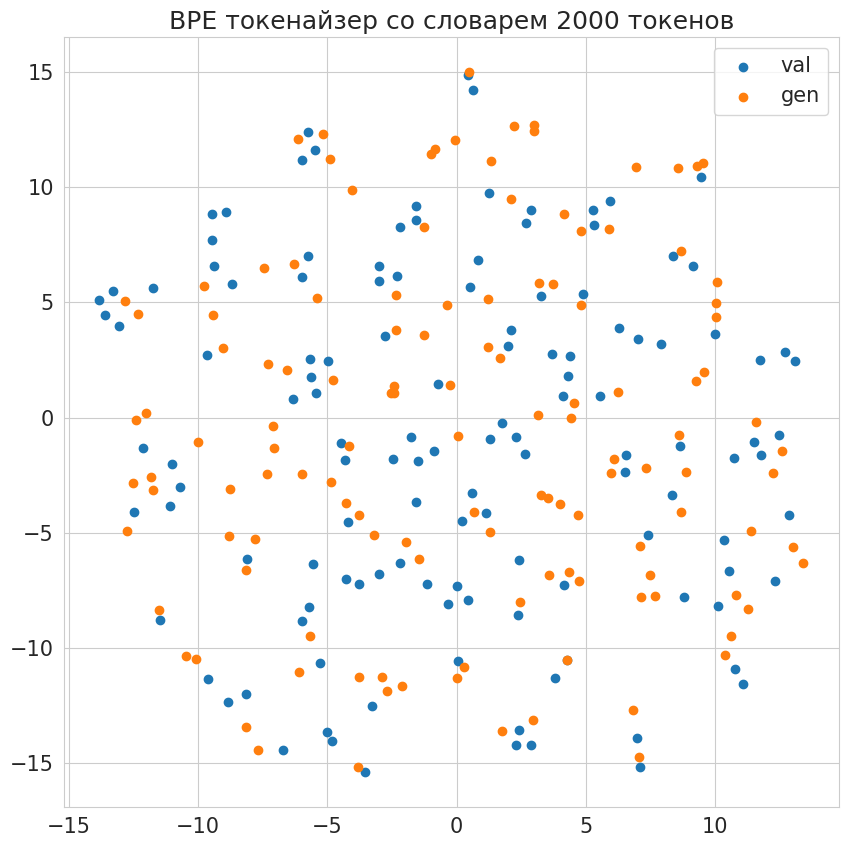

In [37]:

vectors_val_lstm = lstm_v_val[np.random.randint(lstm_v_val.shape[0], size=256)]
vectors_gen_lstm = lstm_v_gen[np.random.randint(lstm_v_gen.shape[0], size=256)]

points = TSNE(n_components=2, perplexity=40, learning_rate='auto',init='random').fit_transform(vectors_val_lstm + vectors_gen_lstm)

plt.subplots(figsize=(10, 10))
plt.scatter(points[:int(len(vectors_val_lstm) / 2), 0], points[:int(len(vectors_val_lstm) / 2), 1], label='val')
plt.scatter(points[int(len(vectors_val_lstm) / 2):, 0], points[int(len(vectors_val_lstm) / 2):, 1], label='gen')

plt.legend()
plt.title('BPE токенайзер cо словарем 2000 токенов')
plt.show()

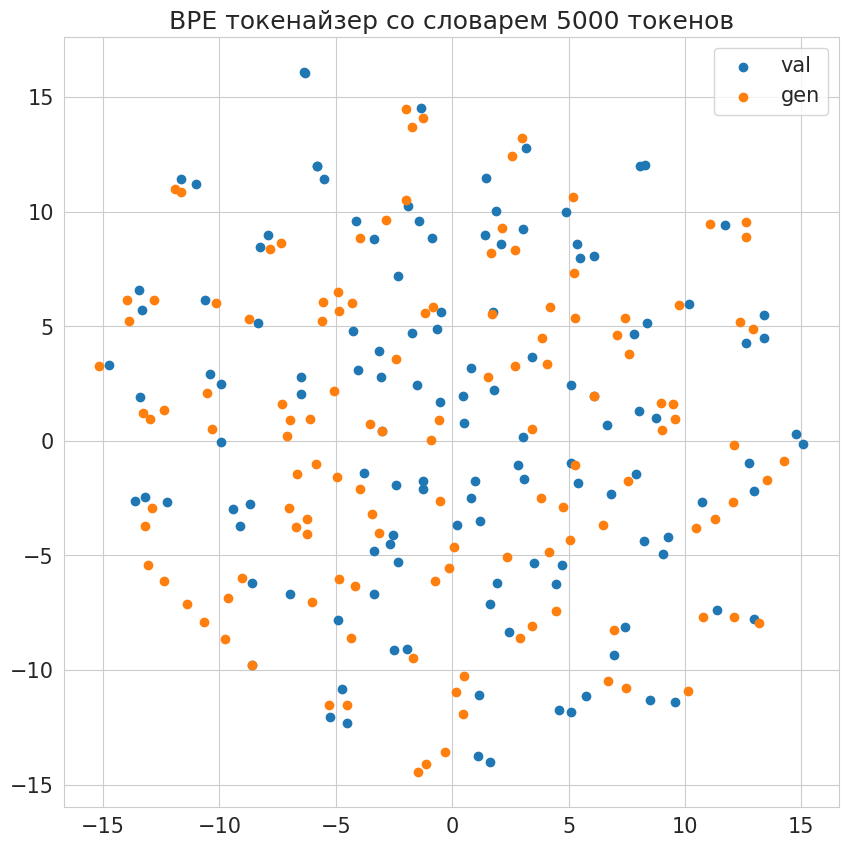

In [38]:
vectors_val_lstm = lstm5000_v_val[np.random.randint(lstm5000_v_val.shape[0], size=256)]
vectors_gen_lstm = lstm5000_v_gen[np.random.randint(lstm5000_v_gen.shape[0], size=256)]

points = TSNE(n_components=2, perplexity=40, learning_rate='auto',init='random').fit_transform(vectors_val_lstm + vectors_gen_lstm)

plt.subplots(figsize=(10, 10))
plt.scatter(points[:int(len(vectors_val_lstm) / 2), 0], points[:int(len(vectors_val_lstm) / 2), 1], label='val')
plt.scatter(points[int(len(vectors_val_lstm) / 2):, 0], points[int(len(vectors_val_lstm) / 2):, 1], label='gen')

plt.legend()
plt.title('BPE токенайзер cо словарем 5000 токенов')
plt.show()

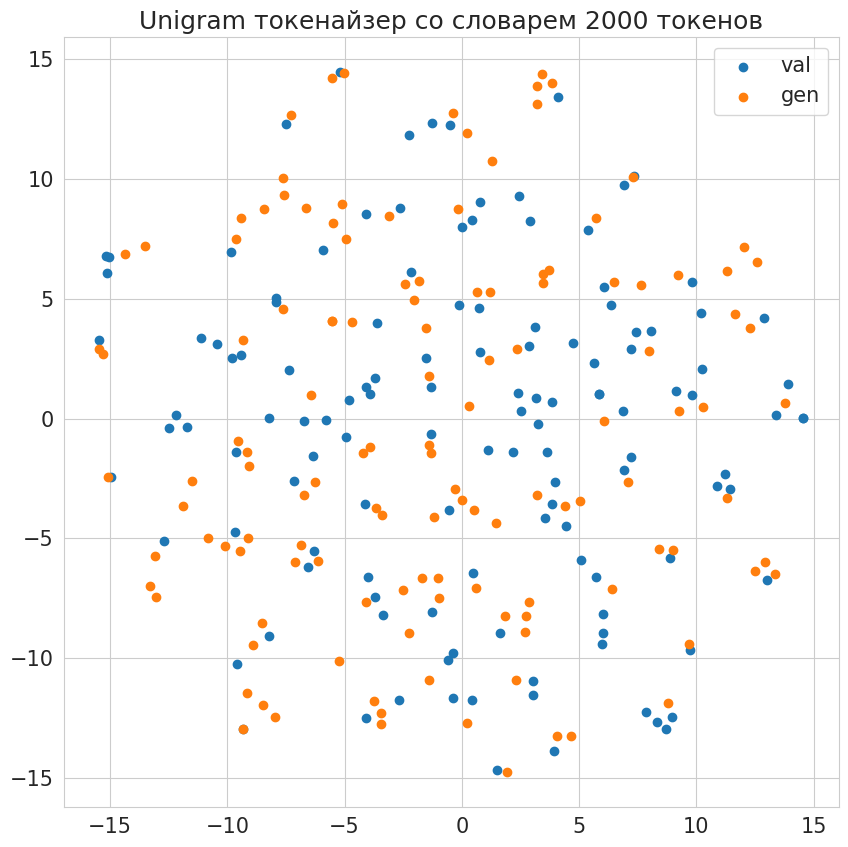

In [40]:
vectors_val_lstm = lstm_unigram_v_val[np.random.randint(lstm_unigram_v_val.shape[0], size=256)]
vectors_gen_lstm = lstm_unigram_v_gen[np.random.randint(lstm_unigram_v_gen.shape[0], size=256)]

points = TSNE(n_components=2, perplexity=40, learning_rate='auto',init='random').fit_transform(vectors_val_lstm + vectors_gen_lstm)

plt.subplots(figsize=(10, 10))
plt.scatter(points[:int(len(vectors_val_lstm) / 2), 0], points[:int(len(vectors_val_lstm) / 2), 1], label='val')
plt.scatter(points[int(len(vectors_val_lstm) / 2):, 0], points[int(len(vectors_val_lstm) / 2):, 1], label='gen')

plt.legend()
plt.title('Unigram токенайзер со словарем 2000 токенов')
plt.show()

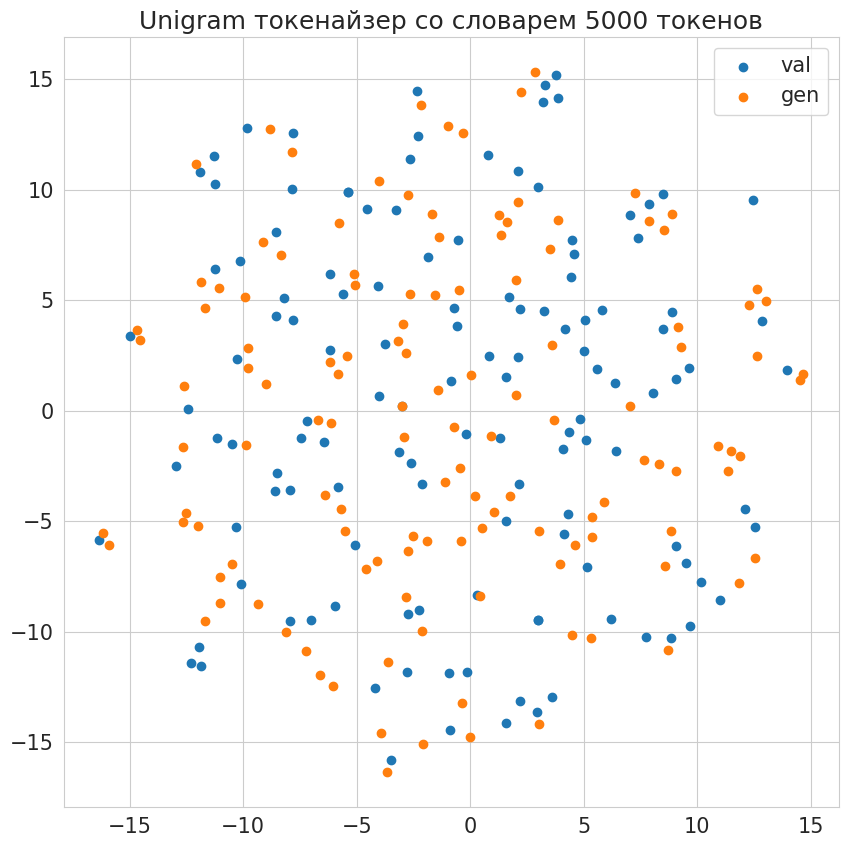

In [41]:
vectors_val_lstm = lstm_unigram5000_v_val[np.random.randint(lstm_unigram5000_v_val.shape[0], size=256)]
vectors_gen_lstm = lstm_unigram5000_v_gen[np.random.randint(lstm_unigram5000_v_gen.shape[0], size=256)]

points = TSNE(n_components=2, perplexity=40, learning_rate='auto',init='random').fit_transform(vectors_val_lstm + vectors_gen_lstm)

plt.subplots(figsize=(10, 10))
plt.scatter(points[:int(len(vectors_val_lstm) / 2), 0], points[:int(len(vectors_val_lstm) / 2), 1], label='val')
plt.scatter(points[int(len(vectors_val_lstm) / 2):, 0], points[int(len(vectors_val_lstm) / 2):, 1], label='gen')

plt.legend()
plt.title('Unigram токенайзер со словарем 5000 токенов')
plt.show()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [42]:

from transformers import AutoTokenizer, AutoModelForCausalLM

RUGPT_TOKENIZER = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
RUGPT_MODEL = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(DEVICE)

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [43]:
def PPL(model, checker_model=RUGPT_MODEL, checker_tokenizer=RUGPT_TOKENIZER):
    size = 1024
    texts = [model.inference() for _ in range(size)]

    encodings = checker_tokenizer("\n\n".join(texts), return_tensors="pt")

    max_length = checker_model.config.n_positions
    stride = 512
    seq_len = encodings.input_ids.size(1)

    nlls = []
    prev_end_loc = 0
    for begin_loc in range(0, seq_len, stride):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(DEVICE)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = checker_model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over input tokens.
            # Multiply it with trg_len to get the summation instead of average.
            # We will take average over all the tokens to get the true average
            # in the last step of this example.
            neg_log_likelihood = outputs.loss * trg_len

        nlls.append(neg_log_likelihood)

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    return torch.exp(torch.stack(nlls).sum() / end_loc)

In [48]:
PPL(lstm)

tensor(483.1729, device='cuda:0')

In [45]:
PPL(lstm5000)

tensor(462.0312, device='cuda:0')

In [46]:
PPL(lstm_unigram)

tensor(511.6188, device='cuda:0')

In [47]:
PPL(lstm_unigram5000)

tensor(449.4624, device='cuda:0')

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

In [73]:
lstm_unigram5000.inference('Поручик Ржевский')

'поручик ржевский- обещали успокоиться, заплатить за сиськи!- не слышите вам заглядывать!'